# FFT สำหรับแต่ละสไลด์ (slice) ในไฟล์ `IMG_0191.mat`

โน้ตบุ๊กนี้ตัวอย่างการ:
1. โหลดไฟล์ `IMG_0191.mat` ที่มีตัวแปรชื่อ `pl`
2. ทำ 2D FFT ให้กับทุกสไลด์ใน volume
3. แสดงภาพเปรียบเทียบ **ภาพต้นฉบับ** กับ **สเปกตรัม (Magnitude ของ FFT)** สำหรับสไลด์ที่เลือก

> ก่อนรันให้แน่ใจว่าอัปโหลดไฟล์ `IMG_0191.mat` ไว้ในโฟลเดอร์เดียวกับโน้ตบุ๊กนี้แล้ว


In [1]:
# ติดตั้ง/นำเข้าไลบรารีที่จำเป็น (สำหรับ Colab ถ้าไม่มี scipy ให้รันบรรทัด !pip ตรงนี้ก่อน)
try:
    import scipy.io as sio
except ImportError:
    # สำหรับ Google Colab ให้ uncomment บรรทัดด้านล่างนี้
    # !pip install scipy
    import scipy.io as sio

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline


In [2]:
# โหลดไฟล์ .mat
file_path = 'IMG_0191.mat'   # เปลี่ยนเป็น path ที่ถูกต้องถ้าไฟล์อยู่คนละโฟลเดอร์
varname = 'pl'              # ชื่อตัวแปรในไฟล์ .mat

mat = sio.loadmat(file_path)
if varname not in mat:
    raise KeyError(f"ตัวแปร '{varname}' ไม่มีในไฟล์ {file_path}")

vol = mat[varname]
print('volume shape =', vol.shape)

if vol.ndim != 3:
    raise ValueError(f'คาดว่าเป็น 3D volume (ny, nx, nz) แต่ได้ shape = {vol.shape}')

ny, nx, nz = vol.shape
print(f'ny = {ny}, nx = {nx}, nz = {nz} (จำนวนสไลด์)')


volume shape = (201, 201, 61)
ny = 201, nx = 201, nz = 61 (จำนวนสไลด์)


In [3]:
# ทำ 2D FFT สำหรับทุกสไลด์ (แกน y,x) พร้อม shift ให้อยู่กลาง
# ผลลัพธ์คือ complex volume ชื่อ fft_vol มีขนาดเท่ากันกับ vol

fft_vol = np.fft.fft2(vol, axes=(0, 1))       # FFT ตามแกน 0 และ 1
fft_vol = np.fft.fftshift(fft_vol, axes=(0, 1))  # shift ให้อยู่กลางสเปกตรัม

print('fft_vol shape =', fft_vol.shape)


fft_vol shape = (201, 201, 61)


## ฟังก์ชันช่วยแสดงภาพสไลด์ + FFT

- เลือกสไลด์ด้วยตัวแปร `k` (เริ่มจาก 0)
- ซ้าย: ภาพต้นฉบับ (intensity)
- ขวา: log-magnitude ของ FFT (เพื่อให้เห็นลายละเอียดในสเปกตรัมชัดขึ้น)


In [4]:
def show_slice_fft(k, vmin=None, vmax=None):
    """แสดงภาพ slice ที่ index = k และสเปกตรัม FFT ของ slice นั้น"""
    if not (0 <= k < nz):
        raise ValueError(f'k ต้องอยู่ระหว่าง 0 ถึง {nz-1}')

    img = vol[:, :, k]
    F = fft_vol[:, :, k]

    # magnitude + log scale เพื่อให้เห็น pattern ชัดขึ้น
    mag = np.abs(F)
    log_mag = np.log1p(mag)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # ภาพต้นฉบับ
    im0 = axes[0].imshow(img, cmap='gray', origin='lower')
    axes[0].set_title(f'Original slice k = {k}')
    axes[0].axis('off')
    divider0 = make_axes_locatable(axes[0])
    cax0 = divider0.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(im0, cax=cax0)

    # สเปกตรัม FFT (log-magnitude)
    im1 = axes[1].imshow(log_mag, cmap='viridis', origin='lower')
    axes[1].set_title('log(1 + |FFT|)')
    axes[1].axis('off')
    divider1 = make_axes_locatable(axes[1])
    cax1 = divider1.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(im1, cax=cax1)

    plt.tight_layout()
    plt.show()


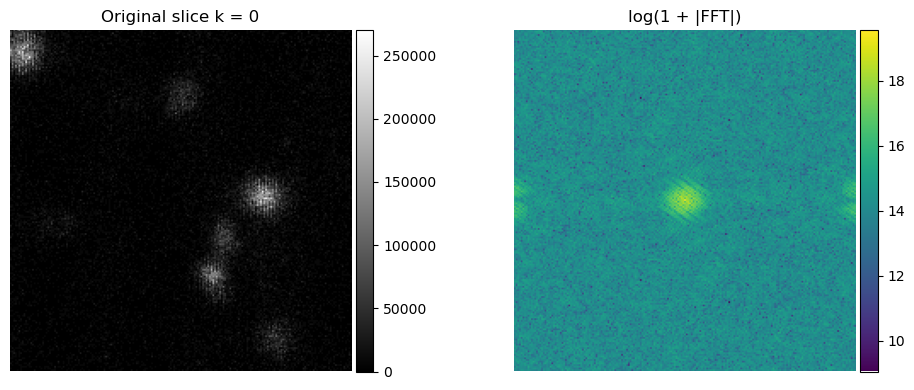

In [ ]:
k = 0 
show_slice_fft(k)


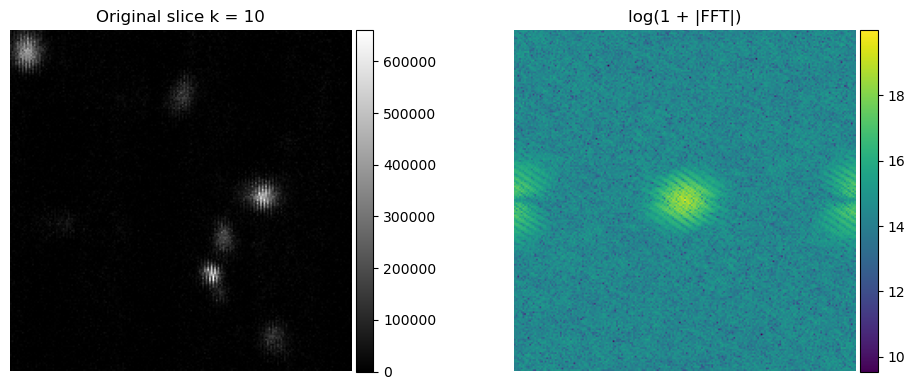

In [ ]:
k = 10 
show_slice_fft(k)


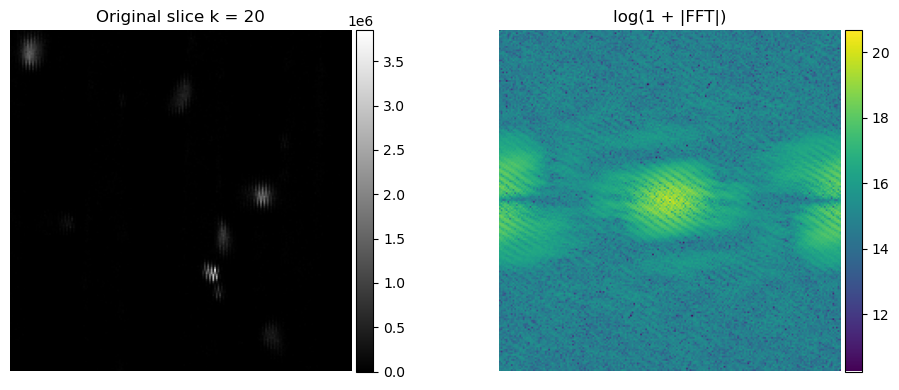

In [ ]:
k = 20 
show_slice_fft(k)


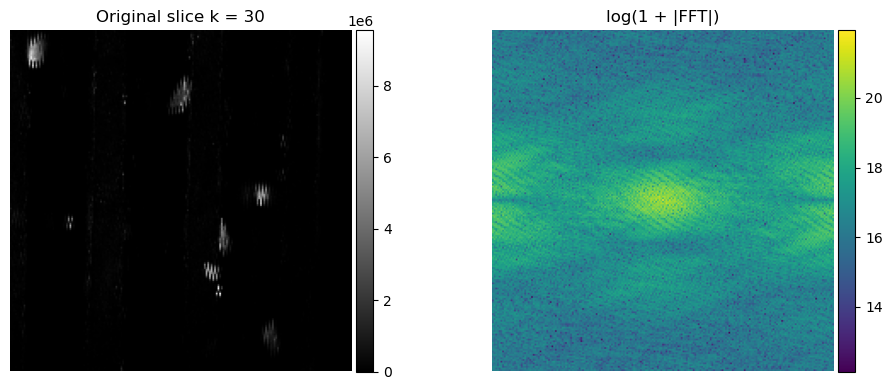

In [ ]:
k = 30 
show_slice_fft(k)


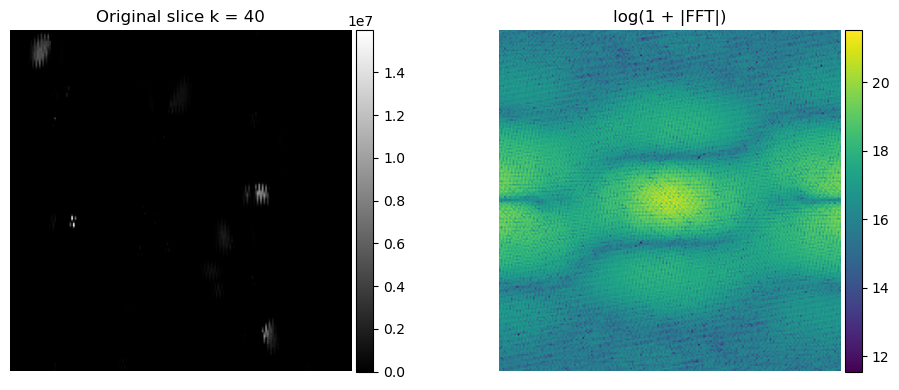

In [ ]:
k = 40 
show_slice_fft(k)


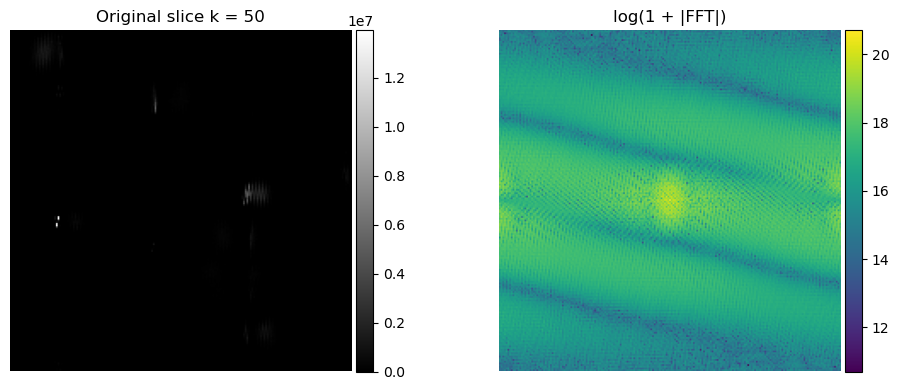

In [ ]:
k = 50 
show_slice_fft(k)


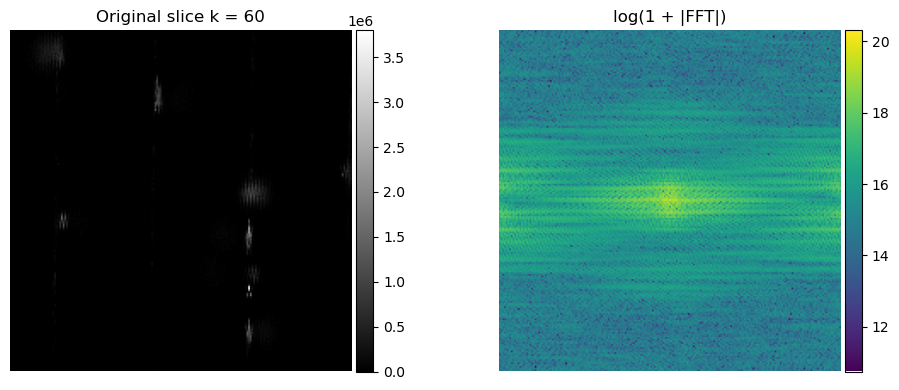

In [ ]:
k = 60 
show_slice_fft(k)


## (เลือกใช้) สร้าง volume ของ magnitude หรือ log-magnitude

ถ้าต้องการนำผล FFT ไปใช้ต่อ เช่น ทำฟิลเตอร์ในโดเมนความถี่ สามารถสร้าง volume ของ magnitude/log-magnitude ได้เลย


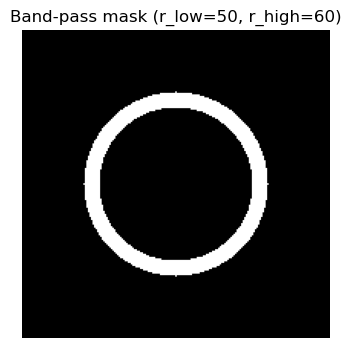

In [41]:
# สร้าง band-pass mask สำหรับโดเมนความถี่
def make_bandpass_mask(shape, r_low, r_high):
    ny, nx = shape
    cy, cx = ny // 2, nx // 2   # จุดกึ่งกลาง (หลัง fftshift แล้ว)

    y, x = np.ogrid[:ny, :nx]
    dist = np.sqrt((y - cy)**2 + (x - cx)**2)

    # เอาเฉพาะระยะที่อยู่ระหว่าง r_low กับ r_high
    mask = (dist >= r_low) & (dist <= r_high)
    return mask.astype(float)

# กำหนดรัศมีที่ต้องการ (ลองปรับเล่นได้)
r_low  =  50   # ต่ำกว่านี้ไม่เอา
r_high = 60   # มากกว่านี้ไม่เอา

mask2d = make_bandpass_mask((ny, nx), r_low, r_high)

plt.figure(figsize=(4,4))
plt.imshow(mask2d, cmap="gray", origin="lower")
plt.title(f"Band-pass mask (r_low={r_low}, r_high={r_high})")
plt.axis("off")
plt.show()


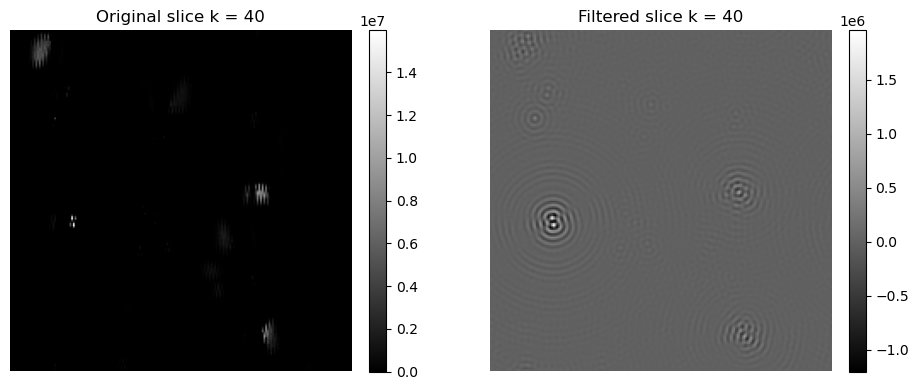

In [42]:
def show_filtered_slice(k):
    if not (0 <= k < nz):
        raise ValueError(f'k ต้องอยู่ระหว่าง 0 ถึง {nz-1}')

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # ต้นฉบับ
    im0 = axes[0].imshow(vol[:, :, k], cmap="gray", origin="lower")
    axes[0].set_title(f"Original slice k = {k}")
    axes[0].axis("off")
    plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

    # หลังฟิลเตอร์
    im1 = axes[1].imshow(vol_filtered[:, :, k], cmap="gray", origin="lower")
    axes[1].set_title(f"Filtered slice k = {k}")
    axes[1].axis("off")
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

# ตัวอย่าง: ดูผลที่ slice  
show_filtered_slice(40)
